# Learning a model

## What are we going to do today?
- Learn a simple model step by step (using synthetic data)
- What's a good predictive model?
- What can we do to obtain a good predictive model?

In contrast we will not focus on the Python,  the pros and cons of different ML algorithms, and preprocessing (as we use synthetic data).

In [1]:
import numpy as np

import scipy as sp
from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams['figure.figsize'] = [8, 3]

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from helper import make_simple_plot, make_plot

from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
LABEL_RELIGIOUS = 'fraction of religious people'
LABEL_ROMNEY = 'probability of voting for Romney'

In [3]:
display(HTML('<a title="United States Congress, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Mitt_Romney_official_US_Senate_portrait_(3x4a).jpg"><img width="256" alt="Mitt Romney official US Senate portrait (3x4a)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Mitt_Romney_official_US_Senate_portrait_%283x4a%29.jpg/256px-Mitt_Romney_official_US_Senate_portrait_%283x4a%29.jpg"></a>'))

Imagine it's 2012.   
Mitt Romney is the presidential candidate for the Republican Party. 
You want to predict the outcome of the election or more specifically the **probability of voting for Mitt Romney in a county**.

You know that election outcomes are depending on factors like **poverty**, **race**, **religiousness** and so on.

You could say:

*The odds of Romney winning are a function of population religiosity, race, poverty, education, and other social and economic indicators.*

We can write: 

$$ y = f(x) $$

$y$: the **variable being predicted**, such as the probability of voting for Romney   
$x$ the **features** we use as an input   
This $x$ could be multi-dimensional, with $x_1$ being poverty, $x_2$ being race, and so on.


Our goal is to estimate $f(x)$.

### A real simple model
To gently step feet in the modelling world, lets consider a very simple model, where the **probability of voting for Romney** is a function only of how **religious the population in a county** is.

- $x$ be the fraction of religious people in a county  
- $y$ be the probability of voting for Romney as a function of $x$. 

### Collect data

In [4]:
display(HTML('<img src="./images/counties_1.png" alt="Drawing" style="width: 300px;"/> <p><b>Created with MapChart.</b></p> <a href="https://www.mapchart.net/usa-counties.html">https://www.mapchart.net/usa-counties.html</a>'))

You're only able to collect a limited number of data points.   
Let's imagine you're visiting **30 counties** all over the US and ask people who they will vote for in the upcoming election.   

The result is a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**.    
Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [5]:
df=pd.read_csv("religion_sample.csv")

In [6]:
df.head()

,promney,rfrac
0,0.108800,0.070000
1,0.170217,0.140000
2,0.171891,0.260000
3,0.163263,0.270000
4,0.242605,0.344716


In [7]:
len(df)

30

In [8]:
x=df.rfrac.values
y=df.promney.values

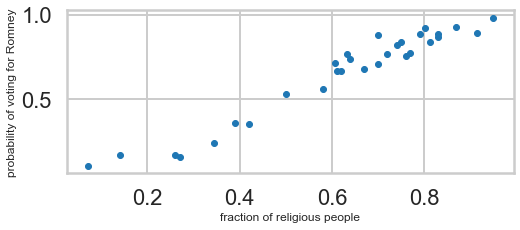

In [9]:
plt.plot(x,y, '.');
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

<details>
    <summary>
        <font size=\"3\" color="green" ><b>What do you notice about the data?</b></font>
    </summary>
    <p>
    <ul>
        <li>The data is correlated</li>
        <li>In general: the more religious the people in a county the higher the probability of voting for Romney</li>
        <li>Both variables range from 0 to 1</li>
        <li>Sampling of x is not uniform: there are more points around x of 0.7</li>
    </ul>
    </p>

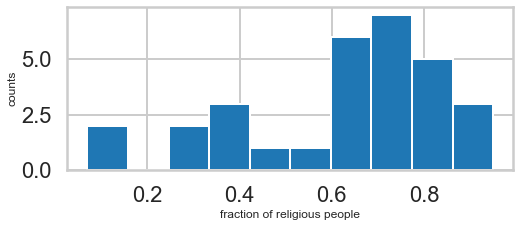

In [10]:
counts, bins = np.histogram(x)
plt.hist(bins[:-1], bins, weights=counts);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel('counts', fontsize=12);

Let's recap:  
You want to predict the **probability of voting for Mitt Romney in a county**. This is our $y$.

To achieve this, you defined a simple model $ y = f(x) $ where the probability of voting for Romney is a function of how religious the population in a county is.

You then collected a sample $\cal{D}$ of 30 data points. 

But you still don't know $f$.

You now want to find a function $\hat{f}$ that might have generated these 30 points of sample data in the _hope_ that this function might approximate $f$ well, and provide us a **predictive model** for future data.

### Let's try to find the best fit

Let's try to find a linear function, i.e. a straight line that best fits the data. Such a line can be described with the following function:
$$ y = f(x) = \beta_0 + \beta_1 x $$


**Which straight line best fits the data best?**

In [11]:
display(HTML('<img src="./images/linreg.png" alt="Drawing" style="width: 200px;"/>'))

We are looking for a straight line, that minimizes the distance from the points to that line.

Usually the **squared distances** are added up in a **loss function**

$$ L_{\cal{D}}(\hat{f}(x)) = \sum_{y_i \in \cal{D}} (y_i - \hat{f}(x_i))^2 $$


Now, given the sample for data $\cal{D}$, we minimize the loss over all possible functions $\hat{f}(x)$ to find the **best fit** function:

$$ \arg\min_{\hat{f}(x)} L_{\cal{D}}(\hat{f}(x)).$$

<details>
    <summary>
        <font size=\"3\" color="green"><b>How would you minimize the loss function $L$ and find the best fit function consequently?</b></font>
    </summary>
    <p>
    <ul>
        <li>Calculate the first derivative of the loss function $L$ and set the result to 0</li>
        <li>You can find a very good step by step guide on how to calculate $\beta_0$ and $\beta_1$ in Handl, Multivariate Analysemethoden, p. 206 </li>
        <li>You can also use a numeric approach like grandient descent</li>
    </ul>
    </p>

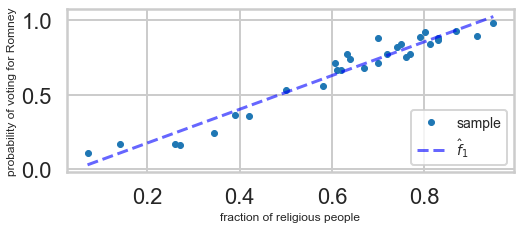

In [12]:
f_1 = np.poly1d(np.polyfit(x, y, 1));
plt.plot(x, y, '.', label="sample");
plt.plot(x, f_1(x), 'b--', alpha=0.6, label="$\hat{f}_1$");
plt.legend(loc=4, fontsize=14);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

You have found the best-fit function to the data $\cal{D}$ from the set of all the straight lines.

**What if the underlying relationship between $x$ and $y$ is not linear, but more complex?**  
Let's consider a general case in the figure below:

In [13]:
display(HTML('<img src="./images/bias.png" alt="Drawing" style="width: 300px;"/>'))

If the underlying relationship is more complex than the model allows, there is always going to be an error then, in approximating $f$ by $\hat{f}$.  
This is called **bias**.   
A biased models leads to **underfitting**.

To address this risk we could simply define a more complex model like:
$$ y = f(x) = \beta_0 + \beta_1 x + \beta_2 x^2$$
Which is a *quadratic* function.

Or a *cubic* function:
$$ y = f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 $$

Or in general a *polynomial* function of order $j$ :
$$ y = f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_m x^m = \sum_{j=0}^{m} \beta_j x^j$$

To see how a more complex model does, let's find the best fit 20th order polynomial.
$$y = f(x) = \sum_{j=0}^{20} \beta_j x^j\,.$$

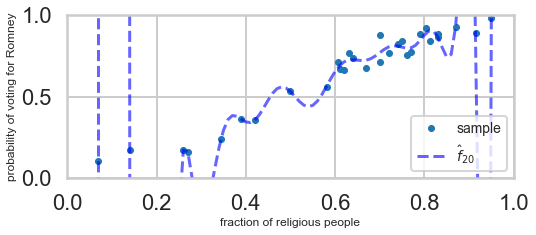

In [14]:
f_20 = np.poly1d(np.polyfit(x,y,20))
plt.plot(x,y, '.', label="sample");
plt.plot(np.arange(0,1,0.01),f_20(np.arange(0,1,0.01)), 'b--', alpha=0.6, label="$\hat{f}_{20}$");
plt.legend(loc=4, fontsize=14);
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

<details>
    <summary>
        <font size=\"3\" color="green"><b>How would you describe the fit?</b></font>
    </summary>
    <p>
    <ul>
        <li>The fit tracks the points much better than the straight line fit</li>
        <li>Or in other words: it follows every observation in very wiggle manner</li>
        <li>Between 0.4 < x < 0.8 the fit is more rubust than for smaller and bigger values of x </li>
    </ul>
    </p>

Let's quantify the quality of both fits by calculating the loss.

$$ L_{\cal{D}}(\hat{f}(x)) = \sum_{y_i \in \cal{D}} (y_i - \hat{f}(x_i))^2 $$

In [15]:
def loss(y, y_pred):
    return sum((y - y_pred)**2)
print('Loss of best straight line fit: ' + str(loss(y, f_1(x))))
print('Loss of best 20th order polynomial fit: ' + str(loss(y, f_20(x))))

Loss of best straight line fit: 0.11113035031356577
Loss of best 20th order polynomial fit: 0.03680751771730077


That's a very clear thing! the 20th order polynomial fit is way better then the straight line fit!

**Are you sure? Who thinks the 20th order polynomial is better? Raise your hands**

**Let's recall what you wanted to do**

We have a **target function** $f(x)$ that we do not know.   
But we do have a **sample** of data points $\cal{D}$.   
We are interested in using this sample to estimate a function $\hat{f}$ to approximate the function $f$, and which can be used for **prediction** at **new data points**, or on the **entire population**. 

To do this, we use an algorithm, called the **learner**, which chooses functions from a set of possible functions and computes a loss $L$ (like the sum of the squared distance over all points in the data set) for each of these functions. It then chooses the function $\hat{f}$ which **minimizes** this loss amonst all the functions. 

Here our learner is called **Polynomial Regression**, and it takes polynomials of order $j$, minimizes the loss measure, and spits out a best-fit hypothesis $\hat{f}_j$.

So again:  
You want to make good predictions on **new data points**.

You are trying to achive this by minimizing the loss on the set of data points we have (our sample) to find $\hat{f}$.

You then *hope* that the loss doesn't particulary change when we apply $\hat{f}$ on new data points.

We saw in the diagram above that $\hat{f}_{20}$ did a good job in tracking the observations, but we still weren't really happy with the result. It feels like $\hat{f}_{20}$ just memorized the data.

**Why is this a problem?**

### Noise
Consider for example two customers of a bank with same age and salaries. One defaults on their mortgage, and the other does not. In this case we have identical $x = (age, salary)$ for these two customers, but different $y$, which is a variable that is 1 if the customer defaulted and 0 otherwise. 

The true $y$ here might be a function of other features, such as marital strife, sickness of parents, etc. But, as the bank, we might not have this information. So we get different $y$ for different customers at the information $x$ that we possess.

A similar thing might be happen in the election example, where we have modelled the probability of voting for Romney as a function of religiousness of the county. There are **many other variables we might not have measured**, such as the majority race in that county, that affect $y$.

So how to take **noise** into account?

Previously we said that
$$ y = f(x) $$

But this is not quite right. When considering noise

$$ y = f(x) + \epsilon $$

$\epsilon$ is a **random** noise term.

So in other words $y$ consists of
- underlying relationship between $x$ and $y$ (represented by the function $f(x)$) which we want to learn
- random noise $\epsilon$ we don't want to learn

We are not very interested in $\epsilon$, but we need to keep in mind that it's there and we need to make sure that the model doesn't fit the noise.

So let's have another look on our 20th order polynomial fit

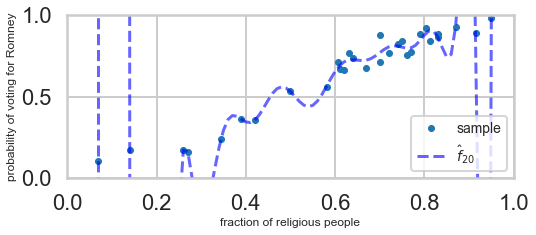

In [16]:
plt.plot(x,y, '.', label="sample");
plt.plot(np.arange(0,1,0.01),f_20(np.arange(0,1,0.01)), 'b--', alpha=0.6, label="$\hat{f}_{20}$");
plt.legend(loc=4, fontsize=14);
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

**What do you think? Who thinks that we are fitting the underlying relationship? Who thinks the noise?**

Let's recall! What's your goal? 

You want to predict the probability of voting for Mitt Romney in a counties **which are not part of our sample (a.k.a. out of sample data)**.

Let's do this. Let's visit another 30 counties, collect the real $y$, apply the prediction, and check how the model does!

In [17]:
df2=pd.read_csv("religion_sample_2.csv")
x2=df2.rfrac.values
y2=df2.promney.values

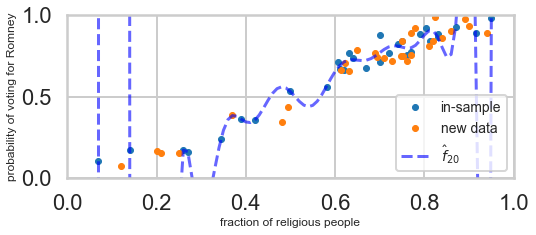

In [18]:
plt.plot(x, y, '.', label="in-sample");
plt.plot(x2, y2,  '.', label="new data");
plt.plot(np.arange(0,1,0.01),f_20(np.arange(0,1,0.01)), 'b--', alpha=0.6, label="$\hat{f}_{20}$");
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.legend(loc=4, fontsize=14);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

The best-fit 20th order polynomial does a reasonable job fitting the in-sample data, and is even well behaved in the middle where we have a lot of in-sample data points. But at places with less in-sample data points, the polynomial wiggles maniacally.

This indicates that we fitted to the noise and this is a danger you will encounter again and again in learning. It's called **overfitting**. The take away lesson from this is that we must further ensure that our **model does not fit the noise**.

Let's recap:   
We have illustrated the terms **overfitting** and **underfitting**.  
- Overfitting: when model fits the noise  
- Underfitting: when model cannot capture the underlying relationship or trend of the data (when it is biased).  

Let's again quantify the quality of both fits by calculating the loss (but now on the new data!).

$$ L_{new\,data}(\hat{f}(x)) = \sum_{y_i \in \, new\,data} (y_i - \hat{f}(x_i))^2 $$

In [19]:
print('Loss of best straight line fit: ' + str(loss(y2, f_1(x2))))
print('Loss of best 20th order polynomial fit: ' + str(loss(y2, f_20(x2))))

Loss of best straight line fit: 0.11871102140565865
Loss of best 20th order polynomial fit: 22326.697260785684


This simple straight line (even it is biased) does better on new data than the way more sophisticated 20th order polynomial. 

### The Variance of your model

Let's stay a little longer at our 20th order polynomial model...

In order to retrieve the sample $\cal{D}$ you visited 30 counties, remember?

In [20]:
display(HTML('<img src="./images/counties_1.png" alt="Drawing" style="width: 500px;"/> <p><b>Created with MapChart.</b></p> <a href="https://www.mapchart.net/usa-counties.html">https://www.mapchart.net/usa-counties.html</a>'))

**How would our fit look like if we would have visited different counties?**

As our data is simulated anyways, let's see what happends if we choose **different 30 points randomly from the population**, and fit both linear and 20th order polynomial models to them. We do this on 200 sets of randomly chosen (from the population) data sets of 30 points each and plot the best fit models.

In [21]:
df_all=pd.read_csv("religion.csv")
x_all=df_all.rfrac.values
y_all=df_all.promney.values

In [22]:
def gen(degree, nsims, size, x, y):
    """
    degree (int) degree of polynomial fit
    nsims (int) number of samples drawn from the population
    size (int) sample size
    x (array) x of population
    y (array) y of population
    """
    outpoly=[]
    for i in range(nsims):
        indexes=np.sort(np.random.choice(x.shape[0], size=size, replace=False))
        pc=np.polyfit(x[indexes], y[indexes], degree) # fitting the model
        p=np.poly1d(pc) 
        outpoly.append(p) # append polynomial function to list
    return outpoly

In [23]:
polys_1 = gen(1, 200, 30, x_all, y_all);
polys_20 = gen(20, 200, 30, x_all, y_all);

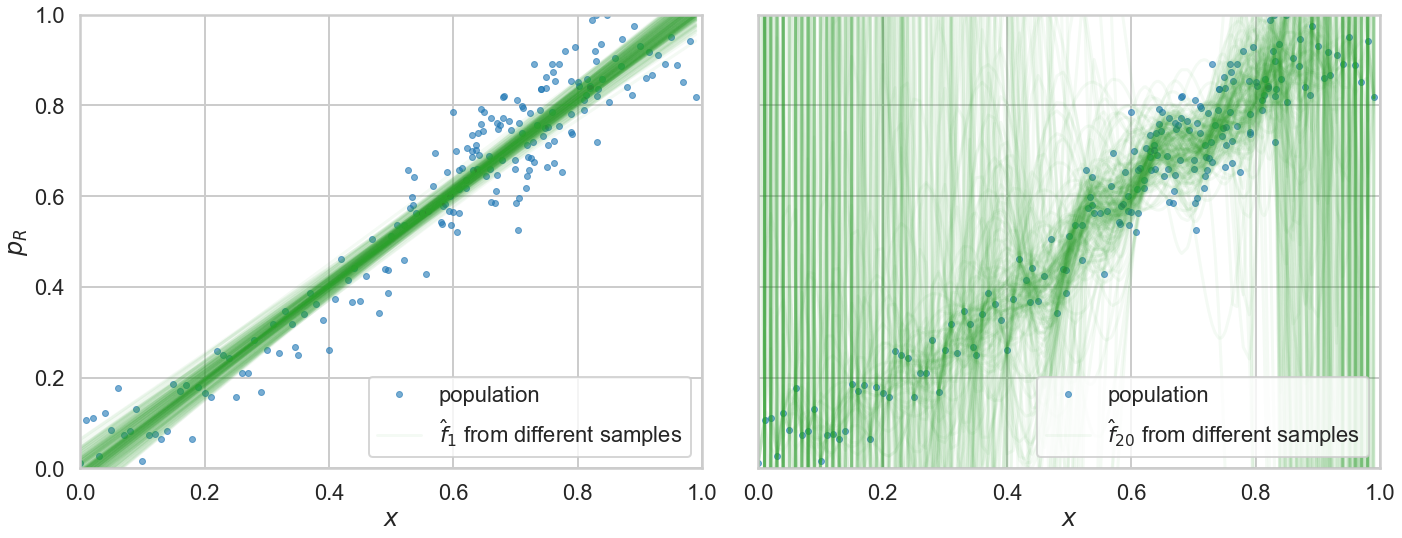

In [24]:
axes=make_plot()
axes[0].plot(x_all, y_all, '.', alpha=0.6, label="population");
axes[1].plot(x_all, y_all, '.', alpha=0.6, label="population");
c=sns.color_palette()[2]
for i, p in enumerate(polys_1[:-1]):
    axes[0].plot(x_all, p(x_all), alpha=0.05, c=c)
axes[0].plot(x_all, polys_1[-1](x_all), alpha=0.05, c=c,label="$\hat{f}_1$ from different samples")
for i, p in enumerate(polys_20[:-1]):
    axes[1].plot(x_all, p(x_all), alpha=0.05, c=c)
axes[1].plot(x_all, polys_20[-1](x_all), alpha=0.05, c=c, label="$\hat{f}_{20}$ from different samples")
axes[0].legend(loc=4);
axes[1].legend(loc=4);

On the left panel, you see the 200 best fit straight lines, each a fit on a different 30 point training sets from the 200 point population. The best-fit lines bunch together, even if they don't quite capture the underlying relationship terribly well. The different samples don't have a big influence in the fit. The fits look more or less the same. The model is quite robust.

On the right panel, we see the same with best-fits for 20th order polynomial models. It is a diaster. While most of the models still band around the central trend of the data $y$, a substantial amount of models veer off into all kinds of noisy hair all over the plot. This is **variance**: the predictions at any given $x$ are all over the place.

The variance can be seen in a different way by plotting the coefficients of the polynomial fit.

In [25]:
pdict1={}
pdict20={}
for i in reversed(range(2)):
    pdict1[i]=[]
    for j, p in enumerate(polys_1):
        pdict1[i].append(p.c[i])
for i in reversed(range(21)):
    pdict20[i]=[]
    for j, p in enumerate(polys_20):
        pdict20[i].append(p.c[i]) 
coeffs_1 = pd.DataFrame(pdict1)
coeffs_20 = pd.DataFrame(pdict20)

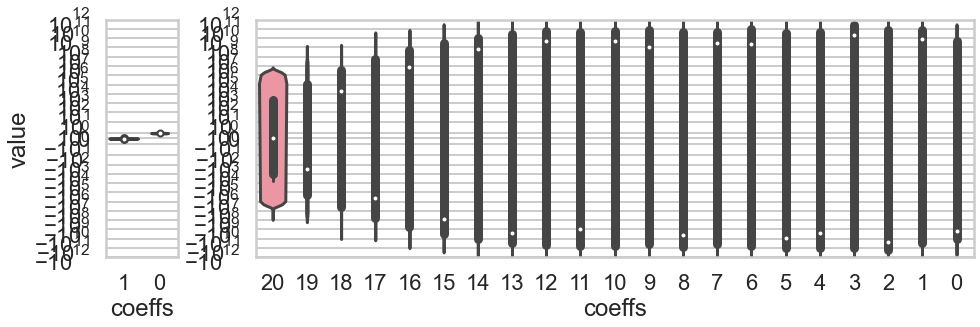

In [26]:
fig = plt.figure(figsize=(14, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 10]) 
axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
axes[0].set_ylabel("value")
axes[0].set_xlabel("coeffs")
axes[1].set_xlabel("coeffs")
plt.tight_layout();
sns.violinplot(data=coeffs_1, ax=axes[0]);
sns.violinplot(data=coeffs_20, ax=axes[1]);
axes[0].set_yscale("symlog");
axes[1].set_yscale("symlog");
axes[0].set_ylim([-1e12, 1e12]);
axes[1].set_ylim([-1e12, 1e12]);

In the right panel we plot the coefficients of the 20th order polynomial fits. This is why we use the word "variance": the spread in the values of the middle coefficients about their means is of the order $10^{10}$ (the vertical height of the bulges), with huge outliers!! The 20th order polynomial fits are a disaster!

Let's recap:

- You learned the effect of noise on this fit, chiefly the problem of overfitting to this noise. 
- You learned the meaning of over- and underfitting as well as bias and variance

The process of learning has two parts:

1. Fit for a model by minimizing the in-sample loss
2. Hope that the in-sample loss approximates the out-of-sample loss well.

Well, we are scientists. Just hoping does not befit us. But we only have a sample. 

**What can we do?**

We already did it. We realized that the 20th order polynomial fit was pretty bad, once we computed the loss of the fit on new data.  
As we ususally only have our sample, we need to hold back some of our sample, and test the performance of our model by trying it out on this held back part!

### Training and Testing  Sets
Let us introduce some new terminology. We take the sample of data $\cal{D}$ that we have been given (our in-sample set) and split it into two parts:

1. The **training set**, which is the part of the data we use to fit a model
2. The **testing set**, a smaller part of the data set which we use to see how good our fit was.

This split is done by choosing points at random into these two sets. Typically we might take 80% of our data and put it in the training set, with the remaining amount going into the test set.

![m:caption](images/train-test.png)

This has of course a downside: The amout of sample data is reduced. But there is no other way to figure out the generalization ability of the fit.

In [27]:
np.random.seed(0)
datasize=df.shape[0]
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= x[itrain]
ytrain = y[itrain]
xtest= x[itest]
ytest = y[itest]

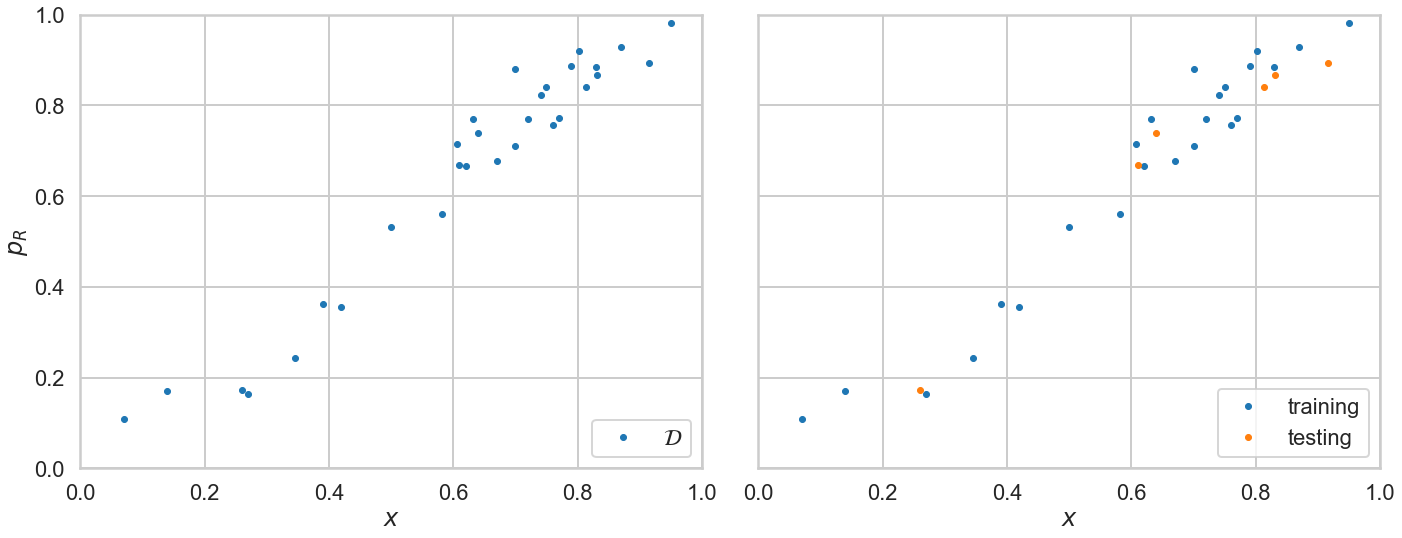

In [28]:
axes=make_plot();
axes[0].plot(x, y, '.', label="$\cal{D}$");
axes[1].plot(xtrain, ytrain, '.', label="training");
axes[1].plot(xtest, ytest, '.', label="testing");
axes[0].legend(loc="lower right");
axes[1].legend(loc="lower right");

### How do training and testing error change with complexity?

The big question still is:   
What order of polynomial should we use to fit the data? Which order is too biased? Which one has too much variance and is too complex? Let us try and answer this question.

We do this by fitting 20 different models (remember the fit is made by minimizing the loss on the training set/the sample), each with increasing dimension `j`, and looking at the training-error and the test-error in each of these models.

In [29]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

In [30]:
degrees = range(21)
loss_train = np.empty(len(degrees))
loss_test = np.empty(len(degrees))

traintestlists = make_features(xtrain, xtest, degrees)

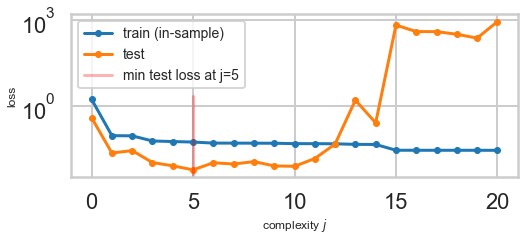

In [31]:
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate loss
    loss_train[d] = loss(ytrain, prediction_on_training)
    loss_test[d] = loss(ytest, prediction_on_test)

plt.plot(degrees, loss_train, marker='.', label='train (in-sample)')
plt.plot(degrees, loss_test, marker='.', label='test')
plt.axvline(np.argmin(loss_test), 0,0.5, color='r', label="min test loss at j=%d"%np.argmin(loss_test), alpha=0.3)
plt.ylabel('loss', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper left', fontsize=14)
plt.yscale("log")

![m:caption](images/complexity-error-plot.png)

We still have one problem.  

**Do you have an idea what's the problem?**

### Validation

We have used the test data to pick $j=5$. But by doing so we have used the test data to "fit" $j$.

$j$ is another parameter (we call it **hyperparameter**) of the model and this parameter (similar to the coefficients $\beta$) needs to be tested how it performs on data not used to fit the model.

![m:caption](images/train-validate-test.png)

In [32]:
#we split the training set down further
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= x[intrain]
yntrain = y[intrain]
xnvalid= x[invalid]
ynvalid = y[invalid]

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid) 
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
#predict on the test set now and calculate error
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)

1


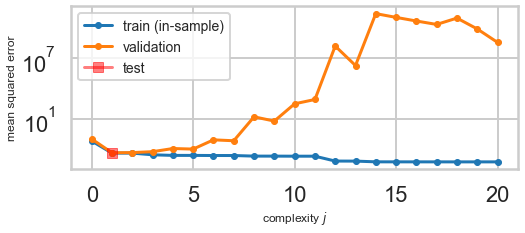

In [33]:
plt.plot(degrees, error_train, marker='.', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='.', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper left', fontsize=14)
plt.yscale("log")
print(mindeg)

The validation loss minimized at polynomial degree of 1.

**What would happen if we do this again, choosing a new random split between training and validation data?**

In [34]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= x[intrain]
yntrain = y[intrain]
xnvalid= x[invalid]
ynvalid = y[invalid]

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid)
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)

3


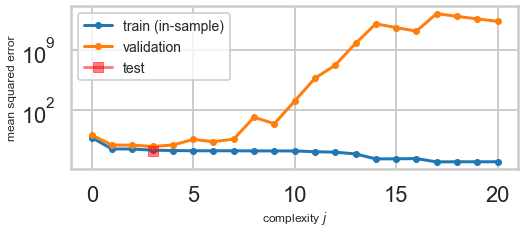

In [35]:
plt.plot(degrees, error_train, marker='.', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='.', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper left', fontsize=14)
plt.yscale("log")
print(mindeg)

This time the validation loss minimizing polynomial degree changed!   
**What happened?**

### Cross Validation
#### The Idea

The smaller the sample the higher the risk that there are specialities/peciliarity in the random splits. In order to not overestimate the loss due to some unfortunate train/test splits, **cross-validation** can be used:

- The train set is splitted into $k$-folds.
- For each model complexitiy (i.e. $j$-th order polynomial)
    - For each fold of the $k$-folds
        - the model is trained on $k-1$ parts
        - The loss is caluclated on the remaining (validation) part
    - In the end the average loss is calculated
- Select the model complexitiy based on the lowest loss
- Train the model on all $k$-folds
- Calculate the loss on the test set

In this way specialties are smoothed out

![m:caption](images/train-cv2.png)

In [36]:
n_folds=4
degrees=range(21)
results=[]
kf = KFold(n_folds)
for d in degrees:
    hypothesisresults=[]
    for train, test in kf.split(range(24)): # split data into train/test groups, 4 times
        tvlist=make_features(xtrain[train], xtrain[test], degrees)
        clf = LinearRegression()
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test], clf.predict(tvlist[d]['test']))) # evaluate score function on held-out data
    results.append((np.mean(hypothesisresults), np.min(hypothesisresults), np.max(hypothesisresults))) # average

In [37]:
mindeg = np.argmin([r[0] for r in results])
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))
c0=sns.color_palette()[0]

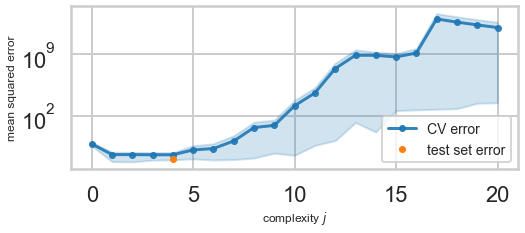

In [38]:
plt.plot(degrees, [r[0] for r in results], marker='.', label='CV error', alpha=0.9)
plt.fill_between(degrees, [r[1] for r in results], [r[2] for r in results], color=c0, alpha=0.2)
plt.plot([mindeg], [err], '.',  label='test set error')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='lower right', fontsize=14)
plt.yscale("log")

We see that the cross-validation loss minimizes at a low degree, and then increases. Because we have so few data points the spread in fold losses increases as well.

In [39]:
y_hat = clf.predict(PolynomialFeatures(4).fit_transform(np.arange(0,1,0.01).reshape(-1,1)))

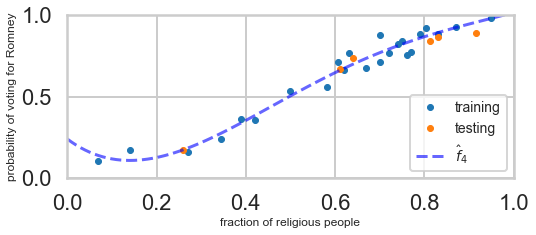

In [40]:
plt.plot(xtrain, ytrain, '.', label="training");
plt.plot(xtest, ytest, '.', label="testing");
plt.plot(np.arange(0,1,0.01), y_hat, 'b--', alpha=0.6, label="$\hat{f}_{4}$");
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.legend(loc=4, fontsize=14);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

## Recap
1. We started with a real world problem
    - find a predictive model which is able to predict the outcome of an election (probability of people voting for Romney in a county)
1. Formulated a model
    - what are factors which affect the outcome of the election?
    - $y = f(x)$ with x fraction of religious people in a county
1. Gathered sample data $\cal{D}$
1. Fitted the data
    - Goal: getting $\hat{f}$ which is an estimation of $f$ by using the sample data
    - Started by fitting a straight line
1. Bias and Underfitting
1. Fitting the data again (by allowing more complexitiy)
1. Noise, Variance and Overfitting
1. Train- & Test-Split
1. Train-, Validation- & Test-Split
1. $k$-fold Cross Validation